In [1]:
import sys, os
sys.path.insert(0, '/home/niell_lab/Documents/github/FreelyMovingEphys/')
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from projects.ephys.population import Population
from src.utils.path import find
from src.utils.auxiliary import flatten_series
from scipy.interpolate import interp1d
import json
from src.utils.path import auto_recording_name
from scipy.signal import butter, sosfiltfilt
import gc
from tqdm import tqdm
from sklearn.decomposition import PCA

In [2]:
hffm_savepath = '/home/niell_lab/data/freely_moving_ephys/batch_files/021022/hffm'
hffm = Population(savepath=hffm_savepath)
hffm.load(fname='hffm_031822')

reading from /home/niell_lab/data/freely_moving_ephys/batch_files/021022/hffm/hffm_031822.pickle


In [3]:
mpl.rcParams.update({'font.size': 13})
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

In [4]:
def to_color(r,g,b):
    return (r/255, g/255, b/255)
hffm.cmap_movclusts = {
    'all': 'k',
    'movement': to_color(230,135,45), # orange
    'early': to_color(44,140,109), # green
    'late': to_color(46,131,232), # blue
    'biphasic': to_color(222,190,43), # yellow
    'negative': to_color(111,61,175), # purple
    'unresponsive': 'dimgray',
}

# baseline firing rate

Text(0, 0.5, 'active baseline (sp/sec)')

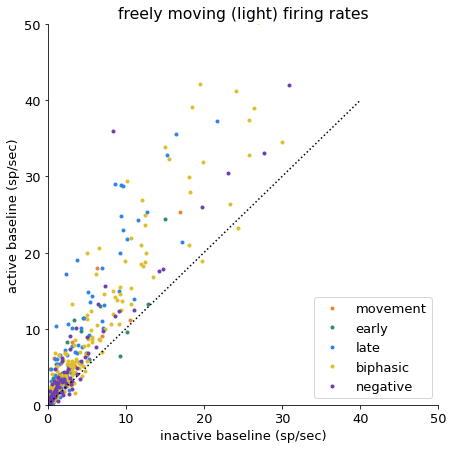

In [15]:
plt.figure(figsize=(7,7))
for i, c in enumerate(['movement','early','late','biphasic','negative']):
    active = hffm.data['FmLt_active_fr'][hffm.data['movcluster1']==c]
    inactive = hffm.data['FmLt_inactive_fr'][hffm.data['movcluster1']==c]
    plt.plot(inactive, active, '.', color=hffm.cmap_movclusts[c], label=c)
plt.plot([0,40],[0,40], '-', color='k', linestyle='dotted')
plt.legend()
plt.xlim([0,50]); plt.ylim([0,50])
plt.title('freely moving (light) firing rates')
plt.xlabel('inactive baseline (sp/sec)'); plt.ylabel('active baseline (sp/sec)')

# PCA on saccades

In [5]:
unit = hffm.data[hffm.data['movcluster1']=='early'].iloc[5]

In [39]:
high_sacc_thresh = 5/.016 # deg/sec
low_sacc_thresh = 3/.016 # deg/sec
gaze_sacc_thresh = 0.6/.016 # deg/sec
trange = hffm.trange.copy()
def all_sacc(row):
    left_gazeshift = row['FmLt_eyeT'][(np.append(row['FmLt_dEye_dps'], 0) > high_sacc_thresh) & (np.append(row['FmLt_dGaze'],0) > high_sacc_thresh)]
    right_gazeshift = row['FmLt_eyeT'][(np.append(row['FmLt_dEye_dps'], 0) < -high_sacc_thresh) & (np.append(row['FmLt_dGaze'], 0) < -high_sacc_thresh)]
    spikeT = row['FmLt_spikeT'].copy()
    right_all = np.zeros([np.size(right_gazeshift), trange.size-1])
    left_all = np.zeros([np.size(left_gazeshift), trange.size-1])
    for i, s in enumerate(np.array(left_gazeshift)):
        left, _ = np.histogram(spikeT-s, trange)
        left_all[i] = left / np.diff(trange)
    for i, s in enumerate(np.array(right_gazeshift)):
        right, _ = np.histogram(spikeT-s, trange)
        right_all[i] = right / np.diff(trange)
    return right_all, left_all


In [40]:
right, left, = all_sacc(unit)

In [41]:
pca = PCA(n_components=10)
pca.fit(right)

PCA(n_components=10)

In [42]:
explvar = pca.explained_variance_

Text(0, 0.5, 'explained variance')

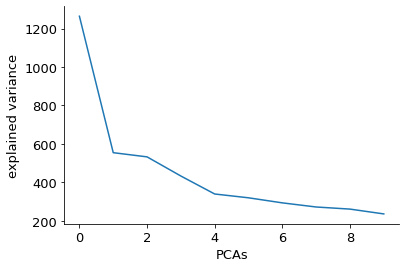

In [43]:
plt.figure()
plt.plot(explvar)
plt.xlabel('PCAs'); plt.ylabel('explained variance')

In [44]:
proj = pca.transform(right)
gproj = proj[:,:2]

In [46]:
gproj.shape

(1206, 2)

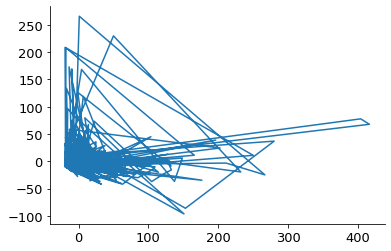

In [48]:
plt.plot(gproj[:,0], gproj[:,1])